In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv'  # Original mounted path from Google Drive
try:
    df = pd.read_csv(file_path, sep='\t', header=None, on_bad_lines='skip')  # Skip bad lines
except TypeError:
    df = pd.read_csv(file_path, sep='\t', header=None, error_bad_lines=False)  # Skip bad lines


In [ ]:
df.columns = ['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']

df['timestamp'] = pd.to_datetime(df['timestamp'])

print("✅ Dataset loaded:")
print(df.head())


✅ Dataset loaded:
       user_id                 timestamp  \
0  user_000001 2009-05-04 23:08:57+00:00   
1  user_000001 2009-05-04 13:54:10+00:00   
2  user_000001 2009-05-04 13:52:04+00:00   
3  user_000001 2009-05-04 13:42:52+00:00   
4  user_000001 2009-05-04 13:42:11+00:00   

                              artist_id artist_name track_id  \
0  f1b1cf71-bd35-4e99-8624-24a6e15f133a   Deep Dish      NaN   
1  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8        坂本龍一      NaN   
2  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8        坂本龍一      NaN   
3  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8        坂本龍一      NaN   
4  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8        坂本龍一      NaN   

                                   track_name  
0  Fuck Me Im Famous (Pacha Ibiza)-09-28-2007  
1           Composition 0919 (Live_2009_4_15)  
2                        Mc2 (Live_2009_4_15)  
3                     Hibari (Live_2009_4_15)  
4                        Mc1 (Live_2009_4_15)  


In [ ]:
df = df.sort_values(by=['user_id', 'track_id', 'timestamp'])

df['prev_timestamp'] = df.groupby(['user_id', 'track_id'])['timestamp'].shift(1)
df['days_since_last_play'] = (df['timestamp'] - df['prev_timestamp']).dt.days

df['replayed_within_30_days'] = df['days_since_last_play'].apply(lambda x: 1 if pd.notnull(x) and x <= 30 else 0)

df = df.dropna(subset=['days_since_last_play'])

print("✅ Preprocessing complete. Sample data with label:")
print(df[['user_id', 'track_name', 'timestamp', 'days_since_last_play', 'replayed_within_30_days']].head())


✅ Preprocessing complete. Sample data with label:
           user_id                        track_name  \
10037  user_000001                   Monday Nightcap   
4206   user_000001              Something In The Way   
161    user_000001              Something In The Way   
39     user_000001              Something In The Way   
3856   user_000001  Squeeze Me (Feat. Ben Westbeech)   

                      timestamp  days_since_last_play  replayed_within_30_days  
10037 2008-04-18 14:44:37+00:00                 163.0                        0  
4206  2008-12-30 01:32:41+00:00                 437.0                        0  
161   2009-04-30 17:00:27+00:00                 121.0                        0  
39    2009-05-02 15:19:46+00:00                   1.0                        1  
3856  2009-01-09 01:13:26+00:00                   1.0                        1  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [ ]:
user_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])

df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek


df['track_name'] = df['track_name'].fillna('')
tfidf = TfidfVectorizer(max_features=100)
track_tfidf = tfidf.fit_transform(df['track_name'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=100)
track_tfidf = tfidf.fit_transform(df['track_name'])

import numpy as np
from scipy import sparse
from scipy.sparse import hstack

numerical_features = df[['user_id_encoded', 'hour', 'dayofweek']].values
numerical_sparse = sparse.csr_matrix(numerical_features)

X = hstack([numerical_sparse, track_tfidf])
y = df['replayed_within_30_days'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Feature engineering done. Data ready for model training.")
print("Train shape:", X_train.shape)


✅ Feature engineering done. Data ready for model training.
Train shape: (10382661, 103)


In [ ]:

df['user_hour'] = df['user_id_encoded'] * 100 + df['hour']
df['user_dayofweek'] = df['user_id_encoded'] * 10 + df['dayofweek']

numerical_features = df[['user_id_encoded', 'hour', 'dayofweek', 'user_hour', 'user_dayofweek']].values
numerical_sparse = sparse.csr_matrix(numerical_features)

X = hstack([numerical_sparse, track_tfidf])
y = df['replayed_within_30_days'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print("✅ Feature engineering done. Data ready for model training.")
print("Train shape:", X_train.shape)

✅ Feature engineering done. Data ready for model training.
Train shape: (10382661, 105)


In [ ]:
!pip install lightgbm -q

import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
!pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.1,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    max_depth=-1
)


print("🚀 Starting model training...")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)]
)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Model Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


🚀 Starting model training...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 7436164, number of negative: 2946497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.043262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
✅ Model Accuracy: 0.7276
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.08      0.14    737590
           1       0.73      0.99      0.84   1858076

    accuracy                           0.73   2595666
   macro avg       0.70      0.53      0.49   2595666
weighted avg       0.72      0.73      0.64   2595666



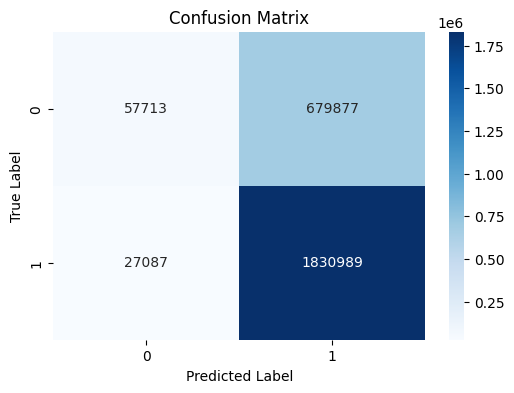

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
random_user = df['user_id'].sample(1).values[0]
print(f"🎯 Randomly selected user: {random_user}")


🎯 Randomly selected user: user_000432


In [ ]:
user_data = df[df['user_id'] == random_user]
print(f"Total interactions found: {len(user_data)}")


Total interactions found: 10207


In [ ]:
feature_names = ['user_id_encoded', 'hour', 'dayofweek', 'user_hour', 'user_dayofweek']


valid_user_ids = df['user_id'].unique()

import random
user_id = random.choice(valid_user_ids)
print(f"🎯 Using user_id: {user_id}")

user_data = df[df['user_id'] == user_id]

while user_data.empty:
  user_id = random.choice(valid_user_ids)
  user_data = df[df['user_id'] == user_id]
  print(f"🎯 Re-sampled user_id: {user_id} due to empty data")


user_features = user_data[feature_names]

import scipy.sparse as sp
user_features_num = user_features.values
user_features_num_sparse = sp.csr_matrix(user_features_num)

user_features_text = tfidf.transform(user_data['track_name'])

user_features_final = sp.hstack([user_features_num_sparse, user_features_text])

user_predictions = model.predict(user_features_final)


user_data['predicted_repeat'] = user_predictions

recommended_songs = user_data[user_data['predicted_repeat'] == 1]['track_name'].unique()

print("🎵 Recommended Songs:")
print(recommended_songs)

🎯 Using user_id: user_000693
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
🎵 Recommended Songs:
['Painter In Your Pocket' "Push The Eagle'S Stomach" 'Travel Is Dangerous'
 'A Dangerous Woman Up To A Point'
 'Concerning The Ufo Sighting Near Highland, Illinois'
 'Good Lovin Outside' 'Sweet Jane' 'Young Alumni' 'Mr. Ambulance Driver'
 'School Of The Flower' 'Direct To Helmet' 'Fortress' 'Specialist'
 "I'M Waking Up To Us" 'Parade Of Punk Rock T-Shirts' 'Call Me Home'
 'Shadows' 'Surf Rider' 'The Pull' 'Mellow Yellow' 'Dagger' 'Funfair'
 "Let'S Not Wrestle Mt. Heart Attack" 'Panic' 'Skin Tension' 'Cup Of Tea'
 'East Hastings' "Moses? I Amn'T" 'Sunworshipper' "Buggin'"
 'The Air In The Mornin

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-34-0fa5fe440883>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['predicted_repeat'] = user_predictions


In [ ]:
import joblib
import json
import os

os.makedirs("/content/drive/MyDrive/models", exist_ok=True)

joblib.dump(model, "/content/drive/MyDrive/models/lightgbm_recommendation_model.pkl")

joblib.dump(tfidf, "/content/drive/MyDrive/models/tfidf_vectorizer.pkl")

joblib.dump(user_encoder, "/content/drive/MyDrive/models/user_encoder.pkl")

with open("/content/drive/MyDrive/models/feature_names.json", "w") as f:
    json.dump(feature_names, f)

print("✅ All models and preprocessors saved successfully!")


✅ All models and preprocessors saved successfully!
